In [1]:
import pandas as pd

train = pd.read_csv('../Deep-Learning-project/dataset/training.csv')
test = pd.read_csv('../Deep-Learning-project/dataset/test.csv')
validation = pd.read_csv('../Deep-Learning-project/dataset/validation.csv')

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    tokenized = word_tokenize(text)  # tokenize text
    cleaned_text = [word for word in tokenized if word not in stopwords.words('english')]  # remove stopwords
    return " ".join(cleaned_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chethanats/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chethanats/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train['cleaned_text'] = train['text'].apply(preprocess_text)
test['cleaned_text'] = test['text'].apply(preprocess_text)
validation['cleaned_text'] = validation['text'].apply(preprocess_text)

labels_dict = {0:'sad', 1:'happy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train['emotion'] = train['label'].map(labels_dict)
test['emotion'] = test['label'].map(labels_dict)
validation['emotion'] = validation['label'].map(labels_dict)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['cleaned_text'])

X_train = tokenizer.texts_to_sequences(train['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test['cleaned_text'])
X_val = tokenizer.texts_to_sequences(validation['cleaned_text'])

# Pad sequences
max_length = max(max(len(x) for x in X_train), max(len(x) for x in X_test), max(len(x) for x in X_val))
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post')

# Encode labels
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['emotion'])

y_train = encoder.transform(train['emotion'])
y_test = encoder.transform(test['emotion'])
y_val = encoder.transform(validation['emotion'])

In [4]:
test.head(10)

,text,label,cleaned_text,emotion
0,im feeling rather rotten so im not very ambiti...,0,im feeling rather rotten im ambitious right,sad
1,im updating my blog because i feel shitty,0,im updating blog feel shitty,sad
2,i never make her separate from me because i do...,0,never make separate ever want feel like ashamed,sad
3,i left with my bouquet of red and yellow tulip...,1,left bouquet red yellow tulips arm feeling sli...,happy
4,i was feeling a little vain when i did this one,0,feeling little vain one,sad
5,i cant walk into a shop anywhere where i do no...,4,cant walk shop anywhere feel uncomfortable,fear
6,i felt anger when at the end of a telephone call,3,felt anger end telephone call,anger
7,i explain why i clung to a relationship with a...,1,explain clung relationship boy many ways immat...,happy
8,i like to have the same breathless feeling as ...,1,like breathless feeling reader eager see happe...,happy
9,i jest i feel grumpy tired and pre menstrual w...,3,jest feel grumpy tired pre menstrual probably ...,anger


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Parameters 
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 100  # Size of the embedding vectors
lstm_units = 64  # Number of units in the LSTM layer

In [6]:
# Model definition
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=lstm_units, return_sequences=False))
model.add(Dropout(0.5))  # Dropout layer added to prevent overfitting
model.add(Dense(units=encoder.classes_.size, activation='softmax'))  


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 100)           1506300   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 1548930 (5.91 MB)
Trainable params: 1548930 (5.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
!pip install pydot
!pip install graphviz

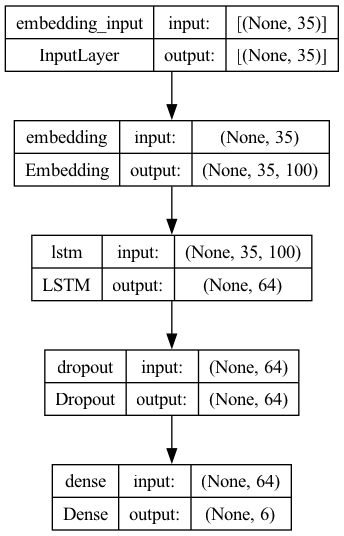

In [9]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='LSTM_model_architecture.png', show_shapes=True)

In [10]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [11]:
# Train the model 
num_epochs = 100
history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    validation_data=(X_val, y_val)
    #callbacks=[early_stopping]  # Add early stopping to training
)

Epoch 1/100
500/500 [==============================] - 11s 21ms/step - loss: 1.5708 - accuracy: 0.3256 - val_loss: 1.3011 - val_accuracy: 0.3820
Epoch 2/100
500/500 [==============================] - 10s 20ms/step - loss: 1.1433 - accuracy: 0.4250 - val_loss: 1.0871 - val_accuracy: 0.4550
Epoch 3/100
500/500 [==============================] - 10s 20ms/step - loss: 0.8770 - accuracy: 0.6001 - val_loss: 0.6785 - val_accuracy: 0.8100
Epoch 4/100
500/500 [==============================] - 11s 21ms/step - loss: 0.3725 - accuracy: 0.8944 - val_loss: 0.3772 - val_accuracy: 0.8725
Epoch 5/100
500/500 [==============================] - 11s 23ms/step - loss: 0.2121 - accuracy: 0.9329 - val_loss: 0.3291 - val_accuracy: 0.9040
Epoch 6/100
500/500 [==============================] - 11s 22ms/step - loss: 0.1414 - accuracy: 0.9569 - val_loss: 0.3120 - val_accuracy: 0.9130
Epoch 7/100
500/500 [==============================] - 11s 22ms/step - loss: 0.1028 - accuracy: 0.9692 - val_loss: 0.3195 - val_ac

500/500 [==============================] - 12s 24ms/step - loss: 0.0094 - accuracy: 0.9962 - val_loss: 0.6497 - val_accuracy: 0.9060
Epoch 58/100
500/500 [==============================] - 12s 24ms/step - loss: 0.0062 - accuracy: 0.9968 - val_loss: 0.7249 - val_accuracy: 0.9050
Epoch 59/100
500/500 [==============================] - 12s 24ms/step - loss: 0.0054 - accuracy: 0.9969 - val_loss: 0.8331 - val_accuracy: 0.9060
Epoch 60/100
500/500 [==============================] - 12s 24ms/step - loss: 0.0062 - accuracy: 0.9973 - val_loss: 0.7829 - val_accuracy: 0.9025
Epoch 61/100
500/500 [==============================] - 11s 22ms/step - loss: 0.0058 - accuracy: 0.9963 - val_loss: 0.8636 - val_accuracy: 0.8985
Epoch 62/100
500/500 [==============================] - 12s 23ms/step - loss: 0.0085 - accuracy: 0.9961 - val_loss: 0.6865 - val_accuracy: 0.9060
Epoch 63/100
500/500 [==============================] - 11s 22ms/step - loss: 0.0079 - accuracy: 0.9964 - val_loss: 0.7443 - val_accuracy

In [12]:
#for epoch, (loss, acc) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
#    print(f'Epoch {epoch+1}: Loss = {loss}, Accuracy = {acc}')

total_loss = 0
total_accuracy = 0
for epoch, (loss, acc) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
    total_loss += loss
    total_accuracy += acc

average_loss = total_loss / num_epochs
average_accuracy = total_accuracy / num_epochs
print(f'Average Loss: {average_loss}, Average Accuracy: {average_accuracy}')

Average Loss: 0.05659899225924164, Average Accuracy: 0.9763781255483628


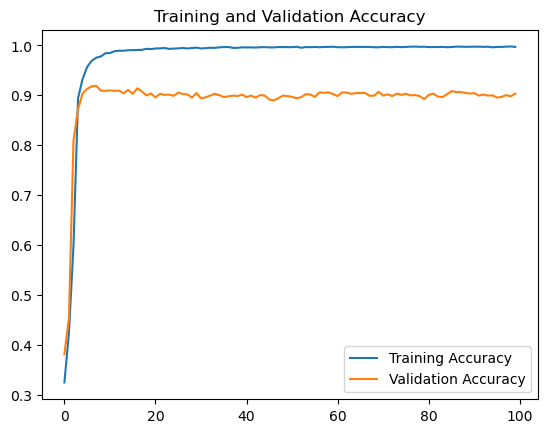

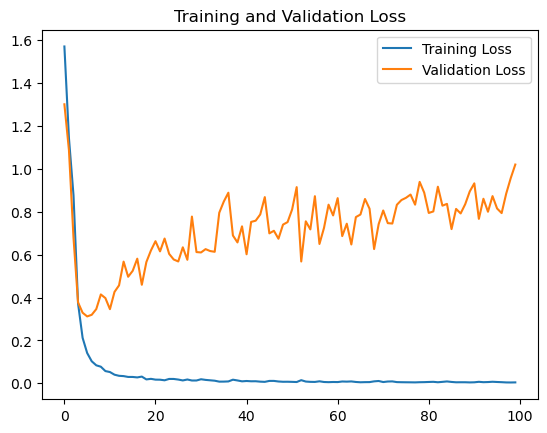

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Predict probabilities for the validation set
probabilities = model.predict(X_val)
# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

print("Accuracy for Validation Data - ",accuracy_score(y_val, predictions)*100)
print(classification_report(y_val, predictions))


63/63 [==============================] - 1s 5ms/step
Accuracy for Validation Data -  90.35
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       275
           1       0.85      0.80      0.83       212
           2       0.93      0.93      0.93       704
           3       0.85      0.83      0.84       178
           4       0.93      0.95      0.94       550
           5       0.75      0.85      0.80        81

    accuracy                           0.90      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.90      0.90      0.90      2000



In [15]:
# Tokenize the test text data
X_test = tokenizer.texts_to_sequences(test['cleaned_text'])
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

# Encode the labels if they are categorical
y_test = encoder.transform(test['emotion'])

# Predict probabilities for the test set
probabilities = model.predict(X_test)
# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

# Evaluate the performance of the LSTM model on the test set
test_accuracy = accuracy_score(y_test, predictions)*100
test_report = classification_report(y_test, predictions)

print("Test Accuracy:", test_accuracy)
print("Classification Report on Test Data:\n", test_report)


63/63 [==============================] - 0s 5ms/step
Test Accuracy: 89.5
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       275
           1       0.90      0.82      0.86       224
           2       0.92      0.94      0.93       695
           3       0.76      0.75      0.76       159
           4       0.93      0.94      0.94       581
           5       0.70      0.71      0.71        66

    accuracy                           0.90      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.89      0.90      0.89      2000



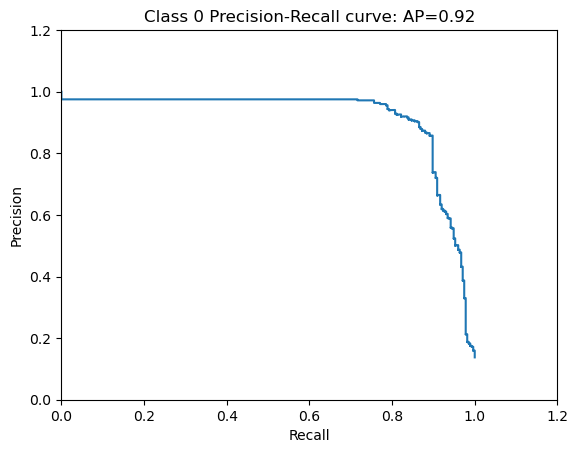

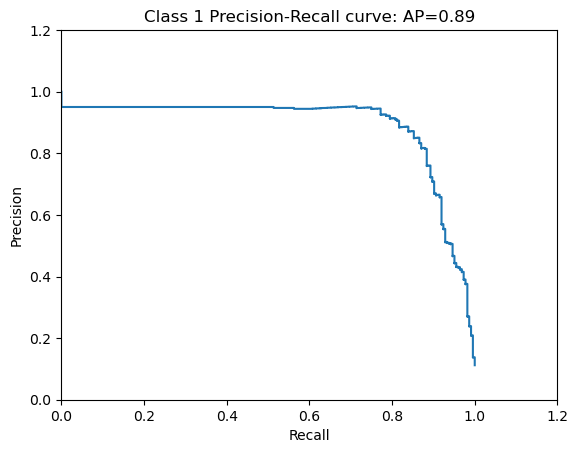

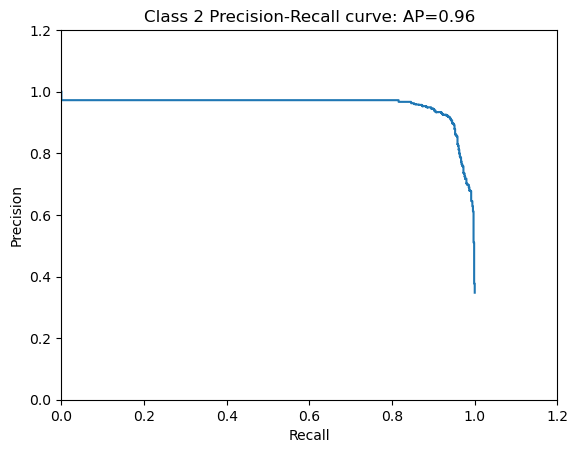

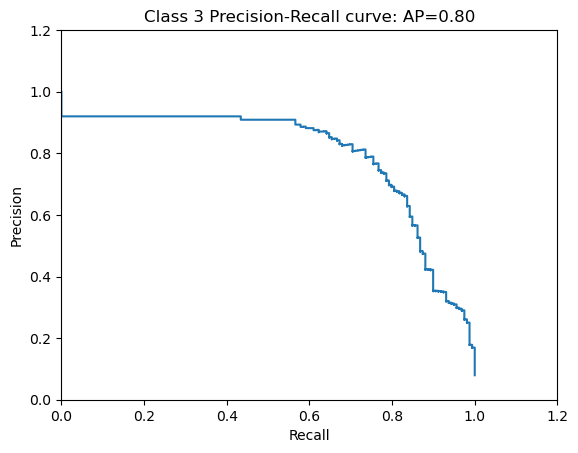

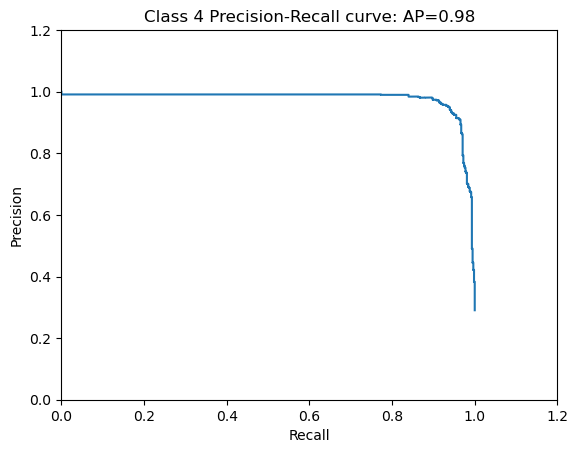

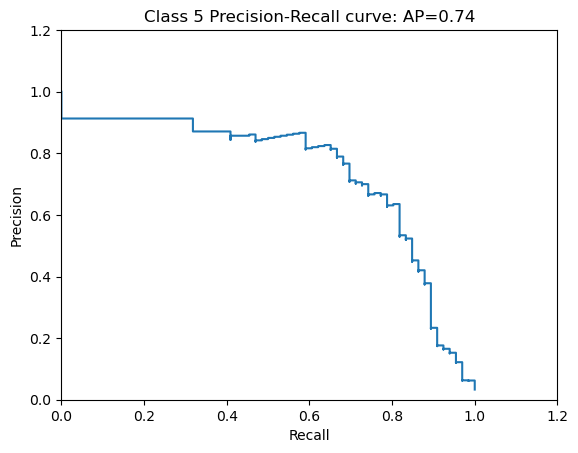

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

n_classes = 6
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

precision = dict()
recall = dict()
average_precision = dict()

# Iterate over each class and compute precision-recall curve
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], probabilities[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], probabilities[:, i])

# Now plot the precision-recall curves
for i in range(n_classes):
    plt.figure()
    plt.step(recall[i], precision[i], where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.2])
    plt.xlim([0.0, 1.2])
    plt.tight_layout
    plt.title(f'Class {i} Precision-Recall curve: AP={average_precision[i]:0.2f}')
    plt.show()

In [18]:
unique_counts = train['emotion'].value_counts()
unique_counts

emotion
happy       5362
sad         4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [19]:
def predict_emotion(text):
    # Preprocess and tokenize the input text
    seq = tokenizer.texts_to_sequences([preprocess_text(text)])
    # Pad the sequence
    padded_seq = pad_sequences(seq, maxlen=max_length, padding='post')
    # Perform the prediction
    prediction = model.predict(padded_seq)
    # Decode the prediction
    label_idx = prediction.argmax(axis=1)[0]
    return encoder.inverse_transform([label_idx])[0]

# Example usage
input_text = input("Enter some sentence:")
predict_emotion(input_text)


Enter some sentence:i love deep learning
1/1 [==============================] - 0s 19ms/step


'happy'